
### Finding Underpriced RVs on Craigslist

![](https://snag.gy/WrdUMx.jpg)

In this project I will be web scraping

> In order to run code from the command line, instead of the notebook, I can just save the code to a file (with a .py extension), and run it using the Python interpreter:<br><br>
> `python my_file.py`

I will be building a process to scrape a single category of search results on Craigslist, that can easily be applied to other categories by changing the search terms.  The main goal is to be able to target and scrape a single page given a set of parameters.

**I use Scrapy, so will provide the code in a folder.**

## Import  libraries for scrapy / requests / pandas / numpy / etc
Setup whichever libraries as need. Review past material for reference.

In [71]:
# PREPARE REQUIRED LIBRARIES
import pandas as pd

import numpy as np
#import pandas.Serie as pd_series


from scrapy.selector import Selector
from scrapy.http import HtmlResponse

import requests

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'



## 1.  Scrape for the largest US cities (non-exhaustive list)
Search, research, and scrape Wikipedia for a list of the largest US cities.  There are a few sources but find one that is in a nice table.  We don't want all cities, just signifficant cities.  Examine the source.  Look for what can be differentiable.

- Use requests
- Build XPath query(ies)
- Extract to a list
- Clean my list

In [2]:
# SCRAPE WIKIPEDIA FOR LARGEST US CITIES (NON-EXHAUSTIVE LIST)
response0 = requests.get("https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population")
HTML0 = response0.text  
HTML0[0:150]

u'<!DOCTYPE html>\n<html class="client-nojs" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8"/>\n<title>List of United States cities by population - Wiki'

In [3]:
cities0 = Selector(text=HTML0).xpath("//tr/td[2]/a/text()").extract()
df0 = pd.DataFrame(cities0)
df0.head()

,0
0,San Antonio
1,San Diego
2,Dallas
3,San Jose
4,San Francisco


In [4]:
# Found this site instead w the top ten cities. 
response = requests.get("http://www.infoplease.com/toptens/largestcities.html")
HTML = response.text  
HTML[0:150]

u'<!DOCTYPE html>\n<html>\n<head>\n\n<link rel="icon" href="http://i.infopls.com/favicon.ico" type="image/x-icon"/>\n<link rel="shortcut icon" href="http://i'

In [5]:

cities = Selector(text=HTML).xpath("//td[@class='ttcontent'][2]/text()").extract()
df = pd.DataFrame(cities)
df

,0
0,"New York, N.Y."
1,"Los Angeles, Calif."
2,"Chicago, Ill."
3,"Houston, Tex."
4,"Philadelphia, Pa."
5,"Phoenix, Ariz."
6,"San Antonio, Tex."
7,"San Diego, Calif."
8,"Dallas, Tex."
9,"San Jose, Calif."


In [6]:
df[0]

0         New York, N.Y.
1    Los Angeles, Calif.
2          Chicago, Ill.
3          Houston, Tex.
4      Philadelphia, Pa.
5         Phoenix, Ariz.
6      San Antonio, Tex.
7      San Diego, Calif.
8           Dallas, Tex.
9       San Jose, Calif.
Name: 0, dtype: object

In [7]:
def city_only(df):
    df_city = []
    for x in range(0,len(df[0])):
        (x_city, x_State) = df[0][x].split(',') 
        #print x_city, df[0][x]
        df_city.append(x_city)

    return df_city
 
cities = city_only(df)

In [8]:
# use replace to get rid of spaces, change to lower case of cities
cities_simpler_lower = [x.lower().replace(' ','') for x in cities]
cities_simpler_lower

[u'newyork',
 u'losangeles',
 u'chicago',
 u'houston',
 u'philadelphia',
 u'phoenix',
 u'sanantonio',
 u'sandiego',
 u'dallas',
 u'sanjose']


## 2.  Write a function to capture current pricing information via Craigslist in one city.
I choose a city from the scraped data, then go to the cooresponding city section on Craigslist, searching for "rv" in the auto section.  I write a method that pulls out the prices.

In [9]:
def rv_info(city):
    
    rv_url1 = "http://"+city+".craigslist.org/search/sss?query=rv"
    #print rv_url1
    response1 = requests.get(rv_url1)
    HTML1 = response1.text  
    HTML1[0:150]

    rv_prices1 = Selector(text=HTML1).xpath("//span[@class='price']/text()").extract()
    df_prices1 = pd.DataFrame(rv_prices1)

    return df_prices1

In [10]:
df = rv_info("sanfrancisco")
df.head()

,0
0,$9999
1,$9999
2,$112
3,$112
4,$11500




## 2.1 Create a mapping of cities to cooresponding regional Craigslist URLs

Major US cities on Craigslist typically have their own cooresponding section (ie: SFBay Area, NYC, Boston, Miami, Seattle, etc).  Later, I will use these to query search results for various metropolitian regions listed on Craigslist.  Between the major metropolitan Craigslist sites, the only thing that will differ is the URL's that correspond to them.

The point of the "mapping":  Create a data structure that allows to iterate with both the name of the city from Wikipedia, with the cooresponding variable that that will allow to construct each craigslist URL for each region.

> For San Francsico (the Bay Area metropolitan area), the url for the RV search result is:
> http://sfbay.craigslist.org/search/sss?query=rv
>
> The convention is http://[region].craigslist.org/search/sss?query=rf
> Replacing [region] with the cooresponding city name will allow to quickly iterate through each regional Craigslist site, and scrape the prices from the search results.  


In [11]:
city_map  = {
    "sanfrancisco":"sfbayarea",
    "sfbayarea":"sfbayarea",
    "newyork": "newyork",
    "nyc": "newyork",
    "losangeles": "losangeles",
    "la":"losangeles",
    "chicago":"chicago",
    "metro_chicago":"chicago",
    "houston":"houston",
    "philadelphia":"philadelphia",
    "philly":"philadelphia",
    "phoenix":"phoenix",
    "sanantonio":"sanantonio",
    "sandiego":"sandiego",
    "dallas":"dallas",
    "the_big_d":"dallas",
    "sanjose":"sfbayarea"
}



## 3. Define a function to caculate mean and median price per city.

Now that I've created a list of cities I want to scrape, I adapt the solution for grabbing data in one region site, to grab data for all regional sites collected, then calculate the mean and median price of RV results from each city.

> I look at the URLs from a few different regions (ie: portland, phoenix, sfbay), and find what they have in common.  I determine the area in the URL string that needs to change the least, and figure out how to replace only that portion of the URL in order to iterate through each city.

In [125]:
def mean_med(rvs):
    
    df2_clean = [float(x.replace('$','')) for x in rvs[0]]
    
    mean_ =  sum(df2_clean) /float(len(df2_clean))
    print "mean is:", mean_
    
    median_ = np.median(np.array(df2_clean))
    print "median is:", median_
    
    return mean_, median_

In [126]:
res3 = {}

for city  in city_map:
    
    df3 = rv_info(city_map[city])
    print city
    (mean1, med1) = mean_med(df3)
    res3[city] = [mean1, med1]
    

houston
mean is: 24961.25
median is: 18491.0
metro_chicago
mean is: 5218.42253521
median is: 200.0
losangeles
mean is: 23214.1176471
median is: 20999.0
sanfrancisco
mean is: 29017.0
median is: 24247.0
sandiego
mean is: 13514.9102564
median is: 214.5
phoenix
mean is: 29704.3010753
median is: 26465.0
sfbayarea
mean is: 29017.0
median is: 24247.0
newyork
mean is: 12518.225
median is: 2000.0
la
mean is: 23214.1176471
median is: 20999.0
philadelphia
mean is: 20835.1666667
median is: 3250.0
sanantonio
mean is: 33754.6363636
median is: 24983.0
the_big_d
mean is: 23692.9538462
median is: 19995.0
dallas
mean is: 23692.9538462
median is: 19995.0
nyc
mean is: 12518.225
median is: 2000.0
philly
mean is: 20835.1666667
median is: 3250.0
chicago
mean is: 5218.42253521
median is: 200.0
sanjose
mean is: 29017.0
median is: 24247.0


In [122]:
# Store results into something like this:
# df = pd.DataFrame({'City':[mean, median]})
# Maybe do a df.T
res3

{'chicago': [5218.422535211268, 200.0],
 'dallas': [23692.953846153847, 19995.0],
 'houston': [24961.25, 18491.0],
 'la': [23214.117647058825, 20999.0],
 'losangeles': [23214.117647058825, 20999.0],
 'metro_chicago': [5218.422535211268, 200.0],
 'newyork': [12518.225, 2000.0],
 'nyc': [12518.225, 2000.0],
 'philadelphia': [20835.166666666668, 3250.0],
 'philly': [20835.166666666668, 3250.0],
 'phoenix': [29704.301075268817, 26465.0],
 'sanantonio': [33754.63636363636, 24983.0],
 'sandiego': [13514.910256410256, 214.5],
 'sanfrancisco': [29017.0, 24247.0],
 'sanjose': [29017.0, 24247.0],
 'sfbayarea': [29017.0, 24247.0],
 'the_big_d': [23692.953846153847, 19995.0]}



## 4. Run now the  scraping process, and save the  results to a CSV file.

In [102]:
# use the resolved url, not the ?q= format
# http://sfbay.craigslist.org/search/rva

rv_cl_data = pd.read_csv('rv_craiglist.csv')
rv_cl_data = pd.read_csv('rv_craiglist.9.2.csv')

In [107]:
rv_cl_data_df = pd.DataFrame(rv_cl_data)

In [116]:
rv_cl_data_df['price'].head()

0    $123388
1    $123388
2    $123388
3    $123388
4    $123388
Name: price, dtype: object

In [119]:
df2_clean = [float(x.replace('$','')) for x in rv_cl_data_df['price']]
    
mean_ =  sum(df2_clean) /float(len(df2_clean))
print "mean for sfbayarea is:", mean_
    
median_ = np.median(np.array(df2_clean))
print "median for sfbayarea is:", median_

mean for sfbayarea is: 31554.25
median for sfbayarea is: 21994.5


In [ ]:
#set up a pipeline for analysis



## 5. Do an analysis of the RV market.

Go head I'll wait.  Anything notable about the data?

In [103]:
df_res3 = pd.DataFrame(res3)

In [104]:
df_res4 = df_res3.T

In [105]:
df_res4.rename(columns={'0':'mean', '1':'median'}, inplace=True)

In [106]:
df_res4

,0,1
chicago,6155.000000,200.0
dallas,24121.000000,19995.0
houston,21121.750000,14944.0
la,26562.875000,20499.0
losangeles,26562.875000,20499.0
metro_chicago,6155.000000,200.0
newyork,9565.348837,1000.0
nyc,9565.348837,1000.0
philadelphia,21229.977528,3500.0
philly,21229.977528,3500.0




### 5.1 Does it makes sense to buy RVs in one region and sell them in another?

Assuming the cost of shipping or driving from one regional market to another.

In [22]:
prices_mean_ordered = df_res4[0].order()
prices_mean_ordered

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: order is deprecated, use sort_values(...)
  if __name__ == '__main__':


chicago           6155.000000
metro_chicago     6155.000000
nyc               9565.348837
newyork           9565.348837
houston          21121.750000
philly           21229.977528
philadelphia     21229.977528
sandiego         23444.512500
dallas           24121.000000
the_big_d        24121.000000
la               26562.875000
losangeles       26562.875000
sfbayarea        28768.350000
sanfrancisco     28768.350000
sanjose          28768.350000
phoenix          28870.223404
sanantonio       40360.857143
Name: 0, dtype: float64

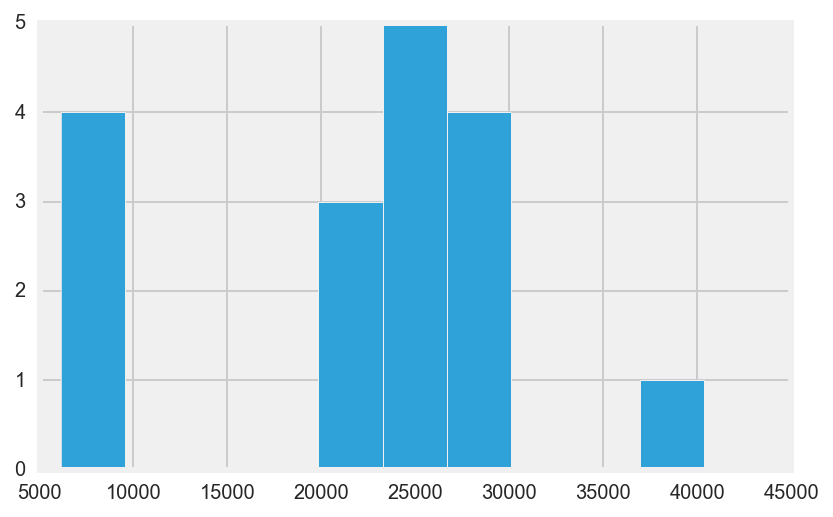

In [23]:
df_res4[0].hist()

In [24]:
prices_median_ordered = df_res4[1].order()
prices_median_ordered

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: order is deprecated, use sort_values(...)
  if __name__ == '__main__':


chicago            200.0
metro_chicago      200.0
sandiego           650.0
nyc               1000.0
newyork           1000.0
philly            3500.0
philadelphia      3500.0
houston          14944.0
dallas           19995.0
the_big_d        19995.0
la               20499.0
sfbayarea        20499.0
sanfrancisco     20499.0
sanjose          20499.0
losangeles       20499.0
phoenix          26230.0
sanantonio       26900.0
Name: 1, dtype: float64

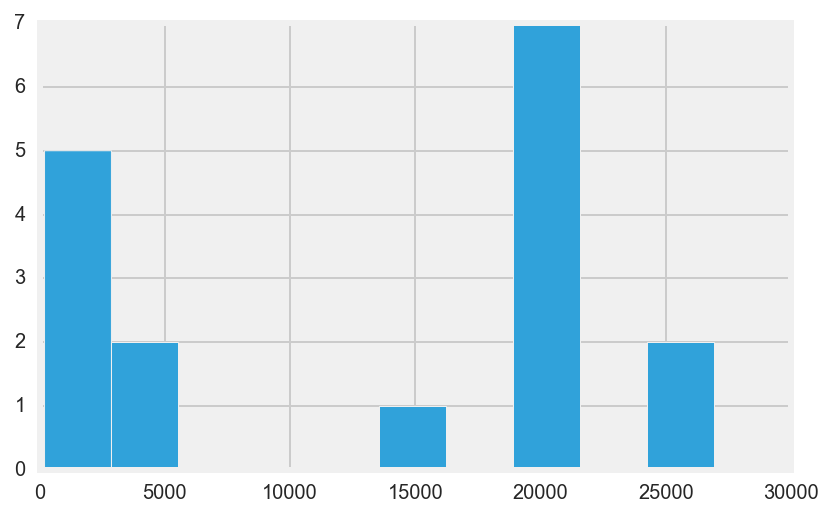

In [25]:
df_res4[1].hist()